In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/archive.zip

Mounted at /content/drive
Archive:  drive/MyDrive/archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [2]:
"Cell that manages imports"
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import wordnet
import random
import numpy as np
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb

In [3]:
"For reproducibility"
MANUAL_SEED = 1337
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)

In [4]:
dir_path = "./"
nltk.download('wordnet')
nltk.download('omw-1.4')
import zipfile
import os

df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
train_datapoints, test_datapoints = [], []
for index, row in df_train.iterrows():
    train_datapoints.append((row["content"], row["label"]))

for index, row in df_test.iterrows():
    test_datapoints.append(( row["content"], row["label"]))

NUM_ID, NUM_OOD = 8, 6
assert NUM_ID + NUM_OOD == 14, "Total number of classes are 14"
ID_MASK = np.concatenate((np.ones(NUM_ID, int), np.zeros(NUM_OOD, int))).astype(bool)
OOD_MASK = ~ID_MASK
ID_CLASSES = np.arange(start=0, stop=14, step=1)[ID_MASK]
OOD_CLASSES = np.arange(start=0, stop=14, step=1)[OOD_MASK]

train_labeled_datapoints, train_unlabeled_datapoints = [], []

np.random.shuffle(train_datapoints); np.random.shuffle(test_datapoints)
label_num = defaultdict(int)
for text, label in train_datapoints:
    if(label in OOD_CLASSES):
        train_unlabeled_datapoints.append(text)
    else:
        label_num[label] += 1
        if(label_num[label] <= 10000): # Putting the first 10,000 samples as train_labeled.
            train_labeled_datapoints.append((text, label))
        else: # Rest 10,000 samples as train_unlabeled...
            train_unlabeled_datapoints.append(text)


<ipython-input-6-dc49739559df>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


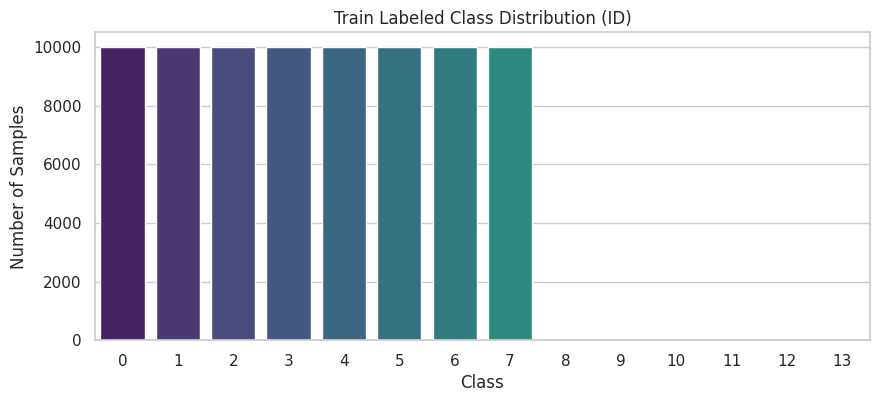

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


train_labels = [label for _, label in train_labeled_datapoints]
train_counts = Counter(train_labels)
all_classes = list(range(14))
train_counts = {cls: train_counts.get(cls, 0) for cls in all_classes}
def plot_class_distribution(counts, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.show()

plot_class_distribution(train_counts, "Train Labeled Class Distribution (ID)")

In [7]:
def _weakaugment(text: str) -> str:
        """
        Weak augmentation -> Randomly deleting some part of the text
        """
        words = text.split()
        if len(words) <= 1:
            return text
        drop_prob = 0.1
        new_words = [word for word in words if random.random() > drop_prob]
        if not new_words:
            new_words = [random.choice(words)]
        return ' '.join(new_words)


def _get_synonym(word: str) -> str:
        synonyms = wordnet.synsets(word)
        if not synonyms:
            return word
        lemma_names = synonyms[0].lemma_names()
        lemma_names = [lemma for lemma in lemma_names if lemma.lower() != word.lower()]
        if lemma_names:
            return random.choice(lemma_names).replace('_', ' ')
        return word

def _strongaugment(text: str) -> str:
    """
    Strong augmentation -> Applies synonym replacement and random word swapping.
    """
    words = text.split()
    if not words:
        return text
    replace_prob = 0.3
    new_words = []
    for word in words:
        if random.random() < replace_prob:
            new_word = _get_synonym(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    swap_prob = 0.2
    for i in range(len(new_words)):
        if random.random() < swap_prob and len(new_words) > 1:
            swap_idx = random.randint(0, len(new_words)-1)
            new_words[i], new_words[swap_idx] = new_words[swap_idx], new_words[i]

    return ' '.join(new_words)

In [8]:
class DBpediaLabeled(Dataset):
    def __init__(self, data, tokenizer, ID_classes, is_train: bool = True, max_len=128):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train
        self.ID_classes = ID_classes

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        text, label = self.data[index]
        text = _weakaugment(text)
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        if(not self.is_train and label not in self.ID_classes):
            label = -1
        return ({
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)}
        , torch.tensor(label, dtype=torch.long))

class DBpediaUnLabeled(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        text = self.data[index]
        text_weak = _weakaugment(text)
        text_strong = _strongaugment(text)
        encoding_weak = self.tokenizer(text_weak, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        encoding_strong = self.tokenizer(text_strong, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")

        return (
            {
                'input_ids': encoding_weak['input_ids'].squeeze(0), # Because it returns encodings in (1, max_length). We convert it to (max_length)
                'attention_mask': encoding_weak['attention_mask'].squeeze(0) # Similarly for the attention_masks, which are basically 0, 1.
            },
            {
                'input_ids': encoding_strong['input_ids'].squeeze(0),
                'attention_mask': encoding_strong['attention_mask'].squeeze(0)
            }
        )

In [11]:
class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.classifier = nn.Linear(in_f, out_f)

    def forward(self, x):
        return self.classifier(x)

feature_dim = 32
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
backbone = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=feature_dim)
classifier = Classifier(feature_dim, len(ID_CLASSES))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
unlabeled_batch_size = 6*512
batch_size = 512
test_size = 1024

In [13]:
train_labeled_dataset = DBpediaLabeled(train_labeled_datapoints, tokenizer, [])
train_unlabeled_dataset = DBpediaUnLabeled(train_unlabeled_datapoints, tokenizer)
test_labeled_dataset = DBpediaLabeled(test_datapoints, tokenizer, ID_CLASSES,is_train=False)
train_labeled_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_unlabeled_dataloader = DataLoader(train_unlabeled_dataset, batch_size=unlabeled_batch_size, shuffle=True, drop_last=True)
test_labeled_dataloader = DataLoader(test_labeled_dataset, batch_size=test_size, shuffle=False, drop_last=True)

$\pi$=1  $\nu$=6

In [14]:
# so what index adds does is takes index Z_l add that particular index of Z_l to index y_l of self, alpha determines the multiplication
"""
Source Pytorch Documentation
self[index[i], :, :] += alpha * src[i, :, :]  # if dim == 0
self[:, index[i], :] += alpha * src[:, i, :]  # if dim == 1
self[:, :, index[i]] += alpha * src[:, :, i]  # if dim == 2
"""
"This function has been tested"
def get_batch_mean(Z, y, num_classes, feature_dim, batch_size, device):
    sums = torch.zeros(num_classes, feature_dim, dtype=Z_l.dtype, device=device)
    counts = torch.zeros(num_classes, dtype=torch.float, device=device)
    sums = sums.index_add(0, y_l, Z_l, alpha=1)
    ones = torch.ones(batch_size, dtype=torch.float, device=device)
    counts = counts.index_add(0, y_l, ones)
    counts[counts == 0] = 1.0
    avg_values = sums / counts.unsqueeze(1) # using broadcasting for division
    return avg_values

"This function has been tested"
"""def subspace_score(Z, batch_means):
    batch_means = torch.transpose(batch_means, 0, 1)
    Q, R = torch.linalg.qr(batch_means)
    Q = Q.unsqueeze(0)
    proj_w = torch.matmul(Q, torch.matmul(torch.transpose(Q, 1, 2), Z.unsqueeze(2))).squeeze(2)
    prod = torch.sum(proj_w * Z, dim=1)
    norm_Z = torch.norm(Z, dim=1, keepdim=True)
    norm_proj_w = torch.norm(proj_w, dim=1, keepdim=True)
    return torch.tensordot(proj_w,Z, dims=2)/(norm_proj_w*norm_Z)"""

'def subspace_score(Z, batch_means):\n    batch_means = torch.transpose(batch_means, 0, 1)\n    Q, R = torch.linalg.qr(batch_means)\n    Q = Q.unsqueeze(0)\n    proj_w = torch.matmul(Q, torch.matmul(torch.transpose(Q, 1, 2), Z.unsqueeze(2))).squeeze(2)\n    prod = torch.sum(proj_w * Z, dim=1)\n    norm_Z = torch.norm(Z, dim=1, keepdim=True)\n    norm_proj_w = torch.norm(proj_w, dim=1, keepdim=True)\n    return torch.tensordot(proj_w,Z, dims=2)/(norm_proj_w*norm_Z)'

In [15]:
import torch
import torch.nn.functional as F

def subspace_score(Z, batch_means):
    """
    Z: (batch_size, feature_dim)
    batch_means: (num_classes, feature_dim)
    Returns:
        cosine similarity between Z and its projection on the subspace
        spanned by batch_means — shape (batch_size, 1)
    """
    Q, _ = torch.linalg.qr(batch_means.T)
    proj_Z = Z @ Q @ Q.T
    cos_sim = F.cosine_similarity(Z, proj_Z, dim=1).clamp(0, 1)
    return cos_sim.unsqueeze(1)


In [16]:
"Taken from the code given by the authors... "
def beta_pdf(x, alpha, beta, loc=0.0, scale=1.0):
    x = (x - loc) / scale
    alpha = torch.as_tensor(alpha, dtype=torch.float32, device=x.device)
    beta = torch.as_tensor(beta, dtype=torch.float32, device=x.device)
    scale = torch.as_tensor(scale, dtype=torch.float32, device=x.device)
    def xlogy(a, b):
        return torch.where(a == 0, torch.zeros_like(b), a * torch.log(b + 1e-10))
    def xlog1py(a, y):
        return torch.where(a == 0, torch.zeros_like(y), a * torch.log1p(y + 1e-10))
    log_unnormalized = xlogy(alpha - 1.0, x) + xlog1py(beta - 1.0, -x)
    log_normalization = torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta)
    log_prob = log_unnormalized - log_normalization
    log_prob = torch.where((x >= 0) & (x <= 1), log_prob, torch.tensor(float('-inf'), device=x.device))
    return torch.exp(log_prob) / scale

def update_beta_parameters(w_id, w_ood, s_l, s_u ,alpha_id, beta_id, alpha_ood, beta_ood, l):
    # Detaching from computational graph so that it won't cause some bullshit error
    w_id = w_id.squeeze(1).detach(); w_ood = w_ood.squeeze(1).detach()
    s_l = s_l.squeeze(1).detach(); s_u = s_u.squeeze(1).detach()
    nu_id = torch.sum(s_l) + torch.dot(w_id, s_u)/(s_l.size(0) + torch.sum(w_id))
    sigma2_id = (torch.sum(s_l - nu_id)**2 + torch.dot(w_id, (s_u - nu_id)**2))/(s_l.size(0) + torch.sum(w_id))

    nu_ood = torch.dot(w_ood, s_u)/(torch.sum(w_ood))
    sigma2_ood = torch.dot(w_ood, (s_u - nu_id)**2)/((torch.sum(w_ood)))

    _alpha_id = nu_id*((nu_id*(1-nu_id))/sigma2_id - 1)
    _alpha_ood = nu_ood*((nu_ood*(1-nu_ood))/sigma2_ood - 1)
    _beta_id = (1 - nu_id)*((nu_id*(1-nu_id))/sigma2_id - 1)
    _beta_ood = (1 - nu_ood)*((nu_ood*(1-nu_ood))/sigma2_ood - 1)

    return alpha_id*l + (1 - l)*_alpha_id, beta_id*l + (1 - l)*_beta_id, alpha_ood*l + (1 - l)*_alpha_ood, beta_ood*l + (1 - l)*_beta_ood

def get_p_id(s, alpha_id, beta_id, alpha_ood, beta_ood, pi=1.0):
    """
    Compute the ID probability using Beta PDFs instead of torch.distributions.Beta,
    following the formulation in the paper (with loc/scale support implicitly assumed as 0/1).
    """
    beta_pdf_id = beta_pdf(s, alpha_id, beta_id)
    beta_pdf_ood = beta_pdf(s, alpha_ood, beta_ood)
    numerator = beta_pdf_id * pi
    denominator = numerator + beta_pdf_ood * (1 - pi)
    p_id = numerator / (denominator + 1e-8)
    return p_id


In [17]:
"this function has been tested"
class SelfSupervisionLoss(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.proj = nn.Linear(in_f, out_f, bias=False)

    def forward(self, x_w, x_s):
        x_s_proj = self.proj(x_s)
        x_w = x_w.detach()
        dot_product = torch.sum(x_s_proj * x_w, dim=1)
        norm_product = torch.norm(x_s_proj, dim=1) * torch.norm(x_w, dim=1)
        cosine_sim = dot_product / (norm_product + 1e-8)
        return -cosine_sim.mean()

"Can't this be negative??"
"Though i did test this.."
class SubspaceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, m_id, m_ood, s_z):
        m_id, m_ood = m_id.to(dtype=float), m_ood.to(dtype=float)
        return torch.mean((m_ood - m_id) * s_z)

"This function has been tested"

class SemiSupervisedLoss(nn.Module):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def forward(self,y_pred, y_true, mask_id):
        """
        logits of model on weakly augmented data: y_true
        logits of model on strongly augmented data: y_pred
        boolean tensors for ID/OOD classification: mask_id
        """
        y_true = y_true.detach()
        batch_size = y_pred.size(0)
        entropy = F.cross_entropy(y_pred, torch.argmax(y_true, dim=1), reduction="none") # input logits, and true labels
        y_prob_true = F.softmax(y_true, dim=1)
        sample_id = torch.logical_and(torch.max(y_prob_true, dim=1)[0] >= self.threshold, (mask_id == 1))
        return (torch.sum(entropy[sample_id]))/batch_size

It should train really fast i believe due to the fact I just use a pretrained fixed model.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epoch = 10
alpha_id, beta_id = torch.tensor(10, device=device),torch.tensor(2, device=device)
alpha_ood, beta_ood = torch.tensor(2, device=device), torch.tensor(10, device=device)
warm_up = 5
lr = 3e-3
backbone.to(device)
classifier.to(device)
supervised_loss_fn = nn.CrossEntropyLoss()
selfsupervised_loss_fn = SelfSupervisionLoss(feature_dim, feature_dim).to(device)
subspace_loss_fn = SubspaceLoss().to(device)
semisupervised_loss_fn = SemiSupervisedLoss(0.9).to(device)
all_params = list(backbone.parameters()) + list(classifier.parameters()) + list(selfsupervised_loss_fn.parameters())
optimizer = torch.optim.SGD(all_params, lr=0.01, momentum=0.9, nesterov=True)
class_means = torch.zeros((len(ID_CLASSES), feature_dim), requires_grad=False, device=device)
class_mean_EMA = 0.2
test_accuracy, test_classification_report, test_confusion_matrix, test_auc_roc_score = [], [], [], []
num_batches = len(train_labeled_dataloader)
batch_means = torch.zeros(len(ID_CLASSES), feature_dim, device=device)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

In [19]:
wandb.init(
    project="dbpedia-ontology",
    name=f"run_{wandb.util.generate_id()}",
    config={
        "epochs": num_epoch,
        "learning_rate": lr,
        "warmup_epochs": warm_up,
        "scheduler": "CosineAnnealingLR",
        "optimizer": "SGD w/ Nesterov",
        "alpha_id": alpha_id.item(),
        "beta_id": beta_id.item(),
        "alpha_ood": alpha_ood.item(),
        "beta_ood": beta_ood.item()
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sujal22514 (sujal22514-indraprastha-institute-of-information-technol) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
for epoch in range(num_epoch):
    backbone.train();classifier.train();selfsupervised_loss_fn.train()
    for (X_l, y_l), (X_w, X_s) in tqdm(zip(train_labeled_dataloader, train_unlabeled_dataloader), total=num_batches, desc="Training:"):
        "========================Loading inputs to device========================"
        labeled_input_ids = X_l['input_ids'].to(device);labeled_attention_mask = X_l['attention_mask'].to(device)
        y_l = y_l.to(device)
        unlabel_weak_input_ids, unlabel_weak_attention_mask = X_w['input_ids'].to(device), X_w['attention_mask'].to(device)
        unlabel_strong_input_ids, unlabel_strong_attention_mask = X_s['input_ids'].to(device), X_s['attention_mask'].to(device)
        "========================Inputs loaded========================"

        "======================= Processing the labeled dataset ======================="
        Z_l = backbone(input_ids=labeled_input_ids, attention_mask=labeled_attention_mask).logits


        "=====================Calculating labeled subspace score============================"
        y_pred_l = classifier(Z_l)
        s_l = subspace_score(Z_l, batch_means.detach())
        "=====================Label subspace score calculated============================"
        "============================Label data processed ============================ "

        "======================= Processing the labeled dataset ======================="
        Z_w_u, Z_s_u = backbone(unlabel_weak_input_ids,unlabel_weak_attention_mask ).logits, backbone(unlabel_strong_input_ids,unlabel_strong_attention_mask).logits

        " ======================= Calculating subspace score and mask ======================="
        s_u = subspace_score(Z_w_u.detach(), batch_means.detach())
        Z_s_u_for_cls = Z_s_u.detach()
        Z_w_u_for_cls = Z_w_u.detach()

        y_pred_u = classifier(Z_s_u_for_cls)
        y_gold_u = classifier(Z_w_u_for_cls)

        prob_id_u = get_p_id(s_u, alpha_id, beta_id, alpha_ood, beta_ood) # size should be (Un_labeled_batch_size)
        prob_ood_u = 1 - prob_id_u
        uniform = torch.rand(unlabeled_batch_size, device=device)
        mask_id = (prob_id_u.squeeze(1) >= uniform)
        mask_ood = ~mask_id
        " ======================= Calculated subspace score and mask ======================="

        " ============================Calculating losses ============================"
        loss_selfsupervised = selfsupervised_loss_fn(Z_w_u, Z_s_u)
        loss_semi_supervised = semisupervised_loss_fn(y_pred_u, y_gold_u, mask_id)
        loss_subspace = subspace_loss_fn(mask_id, mask_ood, s_u)
        loss_supervised = supervised_loss_fn(y_pred_l, y_l)
        " ============================Losses Calculated ============================"

        " ============================ Optimizing the model ============================"
        if epoch < warm_up:
            loss = 40*loss_selfsupervised + loss_supervised
        else:
            loss = 40*loss_selfsupervised + loss_semi_supervised + loss_subspace + loss_supervised
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
        " ============================ Model optimized ============================"

        " ======================== Performing IIM Step ======================== "
        alpha_id, alpha_ood, alpha_ood, beta_ood = update_beta_parameters(prob_id_u,prob_ood_u, s_l, s_u ,alpha_id, beta_id, alpha_ood, beta_ood, 0.2)
        " ======================== IIM step done ======================== "
        "======================= Updating class means ======================="
        batch_means = get_batch_mean(Z_l, y_l, len(ID_CLASSES), feature_dim, batch_size, device)
        class_means = class_means*class_mean_EMA + (1 - class_mean_EMA)*batch_means
        "======================= Class means updataed ======================="
        wandb.log({
            "epoch": epoch,
            "loss_supervised": loss_supervised.item(),
            "loss_selfsupervised": loss_selfsupervised.item(),
            "loss_semi_supervised": loss_semi_supervised.item() if epoch >= warm_up else 0.0,
            "loss_subspace": loss_subspace.item() if epoch >= warm_up else 0.0,
        })


    scheduler.step()
    backbone.eval();classifier.eval();selfsupervised_loss_fn.eval()
    test_predictions,test_targets = [], []
    with torch.inference_mode():
        for X, y_true in test_labeled_dataloader:
            y_true = y_true.to(device)
            input_ids, attention_mask = X["input_ids"].to(device), X["attention_mask"].to(device)
            Z = backbone(input_ids, attention_mask).logits
            y_logits = classifier(Z)
            prob_id = get_p_id(Z, alpha_id, beta_id, alpha_ood, beta_ood)
            y_softmax = F.softmax(y_logits, dim=1)
            y_pred = torch.argmax(y_softmax, dim=1, keepdim=False)
            uniform = torch.rand(size=(test_size, ), device=device)
            y_pred[(torch.max(y_softmax, dim=1)[0] < uniform)] = -1
            test_predictions.extend(y_true.cpu().detach().numpy())
            test_targets.extend(y_pred.cpu().detach().numpy())

    acc = accuracy_score(test_predictions, test_targets)
    print(f"epoch = {epoch}, acc = {acc:.4f}")
    test_accuracy.append(acc)
    test_classification_report.append(classification_report(test_predictions, test_targets, zero_division=0))
    test_confusion_matrix.append(confusion_matrix(test_predictions, test_targets))
    torch.save(backbone.state_dict(), f"backbone_epoch_{epoch}.pth")
    torch.save(classifier.state_dict(), f"classifier_epoch_{epoch}.pth")
    torch.save(selfsupervised_loss_fn.state_dict(), f"selfsupervised_loss_fn_epoch_{epoch}.pth")

wandb.finish()

Training:: 100%|██████████| 156/156 [10:34<00:00,  4.07s/it]


epoch = 0, acc = 0.3750


Training:: 100%|██████████| 156/156 [10:28<00:00,  4.03s/it]


epoch = 1, acc = 0.3759


Training:: 100%|██████████| 156/156 [10:29<00:00,  4.04s/it]


epoch = 2, acc = 0.3767


Training::  48%|████▊     | 75/156 [05:02<05:22,  3.98s/it]

In [ ]:
beta_parameters = torch.stack([alpha_id, beta_id, alpha_ood, beta_ood])
torch.save(beta_parameters, "beta_parameters.pth")
torch.save(batch_means, "batch_means.pth")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.classifier = nn.Linear(in_f, out_f)

    def forward(self, x):
        return self.classifier(x)

class InferenceModelText:
    def __init__(self, backbone_pth, classifier_pth, batch_mean_pth, beta_parameters_pth):
        self.feature_dim = 32
        self.num_classes = 8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

        self.backbone = AutoModelForSequenceClassification.from_pretrained(
            'prajjwal1/bert-tiny',
            num_labels=self.feature_dim
        )
        self.backbone.load_state_dict(torch.load(backbone_pth, map_location=self.device))
        self.backbone = self.backbone.to(self.device)
        self.backbone.eval()
        self.classifier = Classifier(self.feature_dim, self.num_classes)
        self.classifier.load_state_dict(torch.load(classifier_pth, map_location=self.device))
        self.classifier = self.classifier.to(self.device)
        self.classifier.eval()
        self.batch_means = torch.load(batch_mean_pth, map_location=self.device).to(self.device)
        beta_parameters = torch.load(beta_parameters_pth, map_location=self.device).to(self.device)
        self.alpha_id, self.beta_id, self.alpha_ood, self.beta_ood = beta_parameters.chunk(4)

    def _preprocess(self, text):
        encoding = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        return {k: v.to(self.device) for k, v in encoding.items()}

    def __call__(self, text):
        inputs = self._preprocess(text)
        with torch.no_grad():
            outputs = self.backbone(**inputs)
            Z = outputs.logits

            s_score = subspace_score(Z, self.batch_means)
            p_id = get_p_id(
                s_score,
                self.alpha_id.to(self.device),
                self.beta_id.to(self.device),
                self.alpha_ood.to(self.device),
                self.beta_ood.to(self.device)
            )
            if p_id[0] < torch.rand(1, device=self.device):
                return -1
            y = self.classifier(Z)
            return torch.argmax(y, dim=1)


In [ ]:
backbone_pth = "backbone_fsd_kaggle.pth"
classifier_pth = "classifier_epoch_fsd_kaggle.pth"
beta_parameters_pth = "beta_parameters_fsd_kaggle.pth"
batch_mean_pth = "batch_means_fsd_kaggle.pth"

test_inf = InferenceModelText(backbone_pth, classifier_pth, batch_mean_pth, beta_parameters_pth)
print(test_inf("path"))